In [29]:
# 必要なライブラリのインポート
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import ccxt
from datetime import datetime, timedelta
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split
import warnings
import os
import sweetviz as sv
from IPython.display import IFrame
import time
import requests
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import cross_val_score
warnings.filterwarnings('ignore')
from sklearn.ensemble import RandomForestClassifier

In [30]:
# データの読み込みと文字列として保存されている日時情報を日時型のデータに変換
df = pd.read_csv('btc_usdt_1h_2018_to_now.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [31]:
# タイムスタンプでソートとインデックスのリセット
df.sort_values('timestamp', inplace=True)#inplaceで新しいdataframeを作成せず元のを変更
# 列をインデックス（行ラベル）として設定
df.set_index('timestamp', inplace=True)

<Axes: xlabel='timestamp'>

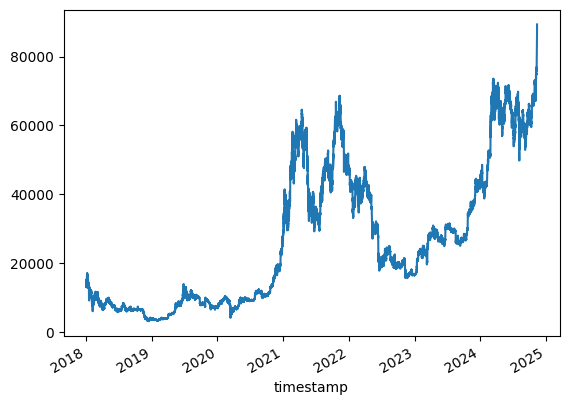

In [32]:
df['close'].plot()

In [33]:
# 特徴量エンジニアリング
# 移動平均線の計算
df['SMA_10'] = df['close'].rolling(window=10).mean()
df['SMA_20'] = df['close'].rolling(window=20).mean()
df['SMA_30'] = df['close'].rolling(window=30).mean()
df['SMA_100'] = df['close'].rolling(window=100).mean()
df['SMA_200'] = df['close'].rolling(window=200).mean()

# 指数移動平均線の計算
df['EMA_20'] = df['close'].ewm(span=20, adjust=False).mean()
df['EMA_200'] = df['close'].ewm(span=200, adjust=False).mean()

# RSIの計算
def compute_RSI(data, time_window):
    diff = data.diff(1) #1つ前の行との違い
    up_chg = diff.clip(lower=0) #差分が負の物は0に変換
    down_chg = -diff.clip(upper=0) #差分が0より大きいものを全て0に置き換える
    up_chg_avg = up_chg.ewm(com=time_window - 1, min_periods=time_window).mean() #価格が上昇した指数移動平均
    down_chg_avg = down_chg.ewm(com=time_window - 1, min_periods=time_window).mean()
    rs = up_chg_avg / down_chg_avg #上昇した強さと下落した強さの比率
    rsi = 100 - 100 / (1 + rs) 
    return rsi

df['RSI_14'] = compute_RSI(df['close'], 14)

# MACDの計算
df['EMA_12'] = df['close'].ewm(span=12, adjust=False).mean()
df['EMA_26'] = df['close'].ewm(span=26, adjust=False).mean()
df['MACD'] = df['EMA_12'] - df['EMA_26']
df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()

# ボリンジャーバンドの計算
df['STD_20'] = df['close'].rolling(window=20).std() #stdは標準偏差(データのばらつき度合い)を計算
df['Upper_Band'] = df['SMA_20'] + (df['STD_20'] * 2)
df['Lower_Band'] = df['SMA_20'] - (df['STD_20'] * 2)

# 遅延特徴量の作成
for lag in range(1, 6): #shift(lag) は、df['close'] のデータを lag 分だけ下にシフト
    df[f'lag_{lag}'] = df['close'].shift(lag) #lag_1からlag_5 までの5つの遅延列が作成

# 時間に関する特徴量
df['hour'] = df.index.hour
df['day_of_week'] = df.index.dayofweek #曜日は0から6の値で表される

#ATR（平均真の範囲、Average True Range）
df['TR'] = df['high'] - df['low']
df['ATR_14'] = df['TR'].rolling(window=14).mean()

#ADX（平均方向性指数、Average Directional Index）
def compute_ADX(data, period=14):
    high = data['high']
    low = data['low']
    close = data['close']
    
    plus_dm = high.diff()
    minus_dm = low.diff()

    plus_dm[plus_dm < 0] = 0
    minus_dm[minus_dm > 0] = 0

    tr = high.combine(low, max) - low.combine(close.shift(), min)

    atr = tr.rolling(window=period).mean()

    plus_di = 100 * (plus_dm.ewm(alpha=1/period).mean() / atr)
    minus_di = abs(100 * (minus_dm.ewm(alpha=1/period).mean() / atr))
    dx = (abs(plus_di - minus_di) / (plus_di + minus_di)) * 100
    adx = dx.rolling(window=period).mean()
    
    return adx

df['ADX_14'] = compute_ADX(df)

#CCI（商品チャンネル指数、Commodity Channel Index）
df['TP'] = (df['high'] + df['low'] + df['close']) / 3
df['CCI_14'] = (df['TP'] - df['TP'].rolling(window=14).mean()) / (0.015 * df['TP'].rolling(window=14).std())

#OBV（オンバランスボリューム、On-Balance Volume）
df['OBV'] = (np.sign(df['close'].diff()) * df['volume']).fillna(0).cumsum()

#Stochastic Oscillator（ストキャスティクス）
df['L14'] = df['low'].rolling(window=14).min()
df['H14'] = df['high'].rolling(window=14).max()
df['%K'] = 100 * (df['close'] - df['L14']) / (df['H14'] - df['L14'])
df['%D'] = df['%K'].rolling(window=3).mean()



In [34]:
# 目標変数の作成
df['return'] = df['close'].pct_change().shift(-1) #前の行とのパーセンテージの変化
df['target'] = (df['return'] > 0).astype(int) #価格が上昇したらTrue

In [35]:
# 欠損値の削除
df.dropna(inplace=True)

In [36]:
# 特徴量と目標変数の定義
features = ['open', 'high', 'low', 'close', 'volume', 'SMA_10', 'SMA_30','SMA_100', 'SMA_200',
            'EMA_20',  'EMA_200', 'RSI_14', 'MACD', 'Signal_Line',
            'Upper_Band', 'Lower_Band', 'ATR_14', 'ADX_14', 'CCI_14', 'OBV', '%K', '%D', 'hour', 'day_of_week'] + [f'lag_{lag}' for lag in range(1,6)]

X = df[features]
y = df['target'] #価格が上昇すれば1下落すれば0

In [37]:
# データの分割（時間ベースでの分割）
split_date = '2024-01-01'
X_train = X[X.index < split_date]
X_test = X[X.index >= split_date]
y_train = y[y.index < split_date]
y_test = y[y.index >= split_date]

In [38]:
# ランダムフォレストモデルの作成と学習
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [39]:
# 予測と評価
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:\n", report)

Accuracy: 0.5036255767963085
Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.80      0.61      3713
           1       0.53      0.22      0.31      3872

    accuracy                           0.50      7585
   macro avg       0.51      0.51      0.46      7585
weighted avg       0.52      0.50      0.46      7585



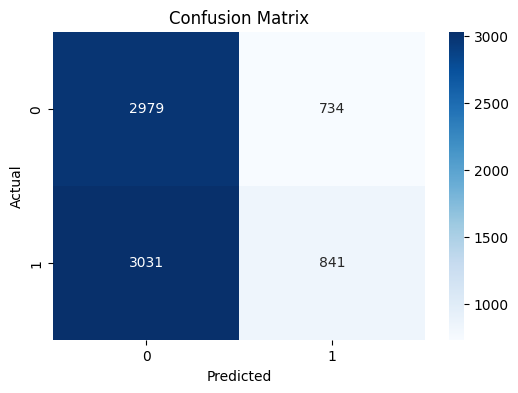

In [40]:
# 8. 混同行列の表示
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [41]:
# ハイパーパラメーターチューニングの設定
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# グリッドサーチの設定（交差検証）
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    scoring='accuracy',
    verbose=3
)

In [42]:
# ハイパーパラメーターチューニングの実行
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 162 candidates, totalling 810 fits
[CV 2/5] END max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=nan total time=   0.0s
[CV 4/5] END max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50;, score=nan total time=   0.0s
[CV 5/5] END max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100;, score=nan total time=   0.0s
[CV 1/5] END max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100;, score=nan total time=   0.0s
[CV 2/5] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.535 total time=  11.5s
[CV 5/5] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.537 total time=  24.1s
[CV 3/5] END max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50;, score=0.534 total time=  12

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 20],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100]},
             scoring='accuracy', verbose=3)

In [43]:
# 最適なハイパーパラメーターの取得
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# チューニング後のモデルで予測
y_pred_tuned = best_model.predict(X_test)

[CV 3/5] END max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=nan total time=   0.0s
[CV 2/5] END max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=nan total time=   0.0s
[CV 1/5] END max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=50;, score=nan total time=   0.0s
[CV 3/5] END max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=nan total time=   0.0s
[CV 3/5] END max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100;, score=nan total time=   0.0s
[CV 1/5] END max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=50;, score=nan total time=   0.0s
[CV 2/5] END max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100;, score=nan total time=   0.0s
[CV 3/5] END max_depth=5, max_features=auto, min_samples_leaf=

In [46]:
# 混同行列の表示
conf_matrix_df = pd.DataFrame(conf_matrix_tuned, 
                              index=['Actual 0', 'Actual 1'], 
                              columns=['Predicted 0', 'Predicted 1'])
print("Confusion Matrix:")
print(conf_matrix_df)

# 最適なハイパーパラメータと精度の表示
print("\nBest Parameters:", best_params)
print("\nAccuracy:", accuracy_tuned)
print("\nClassification Report:\n", report_tuned)

Confusion Matrix:
          Predicted 0  Predicted 1
Actual 0         2808          905
Actual 1         2827         1045

Best Parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}

Accuracy: 0.5079762689518788

Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.76      0.60      3713
           1       0.54      0.27      0.36      3872

    accuracy                           0.51      7585
   macro avg       0.52      0.51      0.48      7585
weighted avg       0.52      0.51      0.48      7585



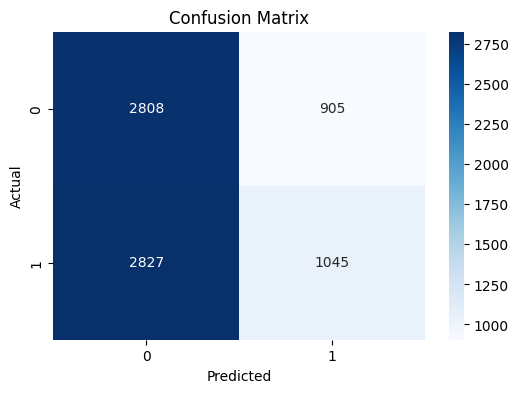

In [48]:
# 8. 混同行列の表示
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_tuned, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()